# CTA data analysis with Gammapy

## NOTE: this notebook is adapted from $GAMMAPY_EXTRA/notebooks/cta_data_analysis.ipynb

## REMEMBER: In order to use all the notebook, you need the use pay attention to the dataset that you created. In the observation definition file used for the simulation on disk, the direction of the pointing MUST NOT be equal to the coordinates of the source, otherwise the notebook cannot estimate the background (see [here](https://www.aanda.org/articles/aa/pdf/2007/18/aa6674-06.pdf) for more informations).

## Caveat

* This notebook was prepared in a hurry, it is incomplete.
* The CTA first data challenge (1DC) data is still in preparation.
* Accessing background models doesn't work yet with Gammapy
* Several other small known issues with the data and Gammapy.
* Work in progress ... please excuse the mess!

## Introduction

The focus of this notebook is on demonstrating how to quickly perform a standard analysis of a given target in the sky. The gammapy functions and classes that we'll use won't be explained in detail. Please refer to the other gammapy tutorial notebooks, if you're interested.

At some point there should be a convenience class to make this kind of analysis easier, feedback on how this should be implemented is welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions, if something goes wrong here you won't be able to run the notebook
import gammapy
import numpy as np
import astropy
import regions
import sherpa
import uncertainties
import photutils

print('gammapy:', gammapy.__version__)
print('numpy:', np.__version__)
print('astropy:', astropy.__version__)
print('regions:', regions.__version__)
print('sherpa:', sherpa.__version__)
print('uncertainties:', uncertainties.__version__)
print('photutils:', photutils.__version__)

('gammapy:', u'0.7.dev4820')
('numpy:', '1.13.1')
('astropy:', u'2.0')
('regions:', u'0.2')
('sherpa:', '4.9.0')
('uncertainties:', '3.0.1')
('photutils:', u'0.3.2')


In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from photutils.detection import find_peaks
from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)
from gammapy.image import SkyImage, IACTBasicImageEstimator
from gammapy.background import RingBackgroundEstimator, ReflectedRegionsBackgroundEstimator
from gammapy.utils.energy import EnergyBounds
from gammapy.detect import TSImageEstimator

In [4]:
# Setup the logger
import logging
logging.basicConfig()
log = logging.getLogger('gammapy.spectrum')
log.setLevel(logging.ERROR)

## Load Data

First, we have to load the CTA data exported to fits format (the format is described in detail [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/)).

In [5]:
#DATA_DIR = '$GAMMAPY_EXTRA/test_datasets/cta_1dc'
DATA_DIR = 'dataset_test'
# DATA_DIR = '/Users/deil/1dc/1dc.pre'

data_store = DataStore.from_dir(DATA_DIR)
data_store.info()


Data store summary info:
name: noname

HDU index table:
BASE_DIR: dataset_test
Rows: 24
OBS_ID: 1 -- 4
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']

Observation table:
Number of observations: 4


In [6]:
print(data_store.obs_table.colnames)
obs_colnames = ['OBS_ID', 'DATE_OBS', 'TIME_OBS', 'GLON_PNT', 'GLAT_PNT']
data_store.obs_table[::1][obs_colnames]

['OBS_ID', 'RA_PNT', 'DEC_PNT', 'GLON_PNT', 'GLAT_PNT', 'ZEN_PNT', 'ALT_PNT', 'AZ_PNT', 'ONTIME', 'LIVETIME', 'DEADC', 'TSTART', 'TSTOP', 'DATE_OBS', 'TIME_OBS', 'DATE_END', 'TIME_END', 'EVENTS_FILENAME', 'EVENT_COUNT', 'EVENT_TIME_MIN', 'EVENT_TIME_MAX', 'EVENT_ENERGY_MIN', 'EVENT_ENERGY_MAX']


OBS_ID,DATE_OBS,TIME_OBS,GLON_PNT,GLAT_PNT
int64,str10,str8,float64,float64
1,2000-01-01,11:58:56,184.201919204,-4.46983236553
2,2000-01-01,12:28:56,184.201919204,-4.46983236553
3,2000-01-01,12:58:56,184.201919204,-4.46983236553
4,2000-01-01,13:28:56,184.201919204,-4.46983236553


## Select observations

In [7]:
# I've only copied EVENTS for these three obs for testing
# Trying to access any other will fail!
obs_id = [1, 2, 3,4]
obs_list = data_store.obs_list(obs_id)

In [8]:
data_store.obs_table.select_obs_id(obs_id)[obs_colnames]

OBS_ID,DATE_OBS,TIME_OBS,GLON_PNT,GLAT_PNT
int64,str10,str8,float64,float64
1,2000-01-01,11:58:56,184.201919204,-4.46983236553
2,2000-01-01,12:28:56,184.201919204,-4.46983236553
3,2000-01-01,12:58:56,184.201919204,-4.46983236553
4,2000-01-01,13:28:56,184.201919204,-4.46983236553


In [9]:
obs = obs_list[0]

In [10]:
print(obs)

Info for OBS_ID = 1
- Start time: 0.00
- Pointing pos: RA 84.63 deg / Dec 23.01 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 5.000 %



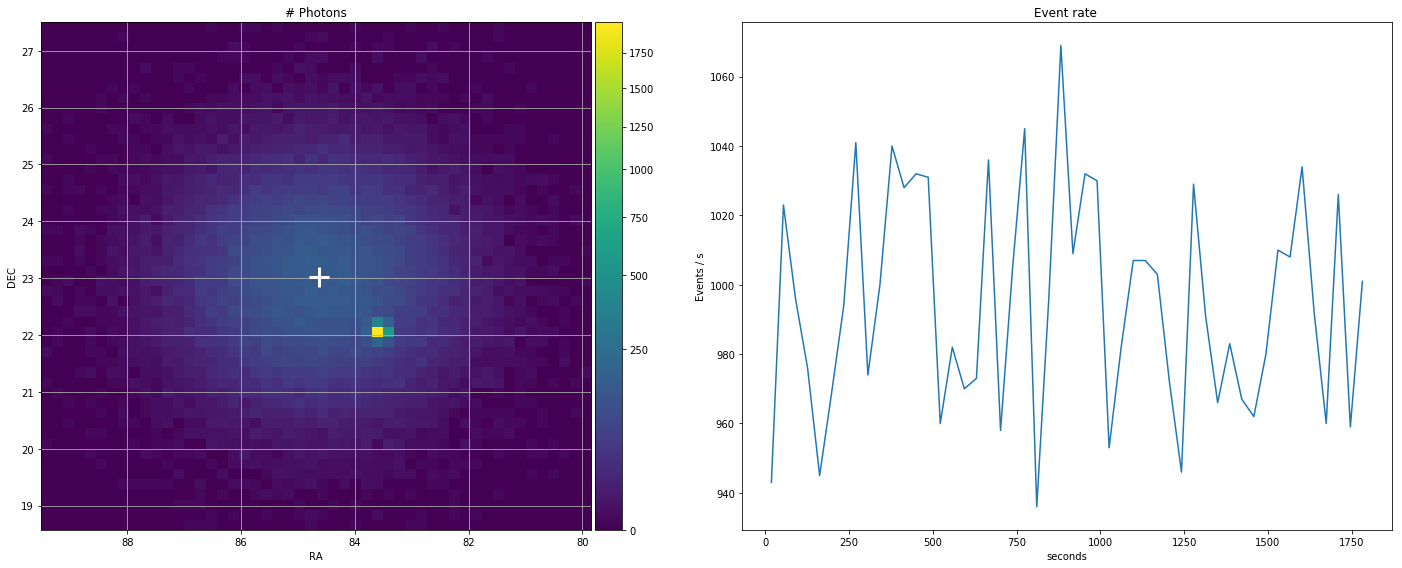

In [11]:
obs.events.peek()

/usr/lib64/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)


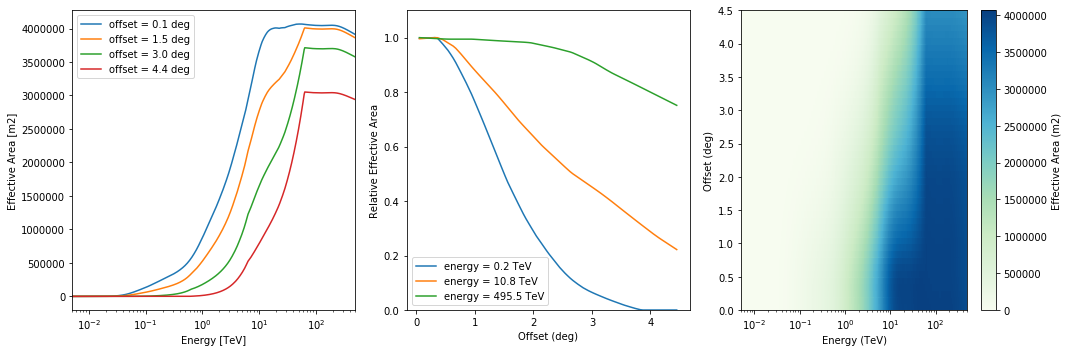

In [12]:
obs.aeff.peek()

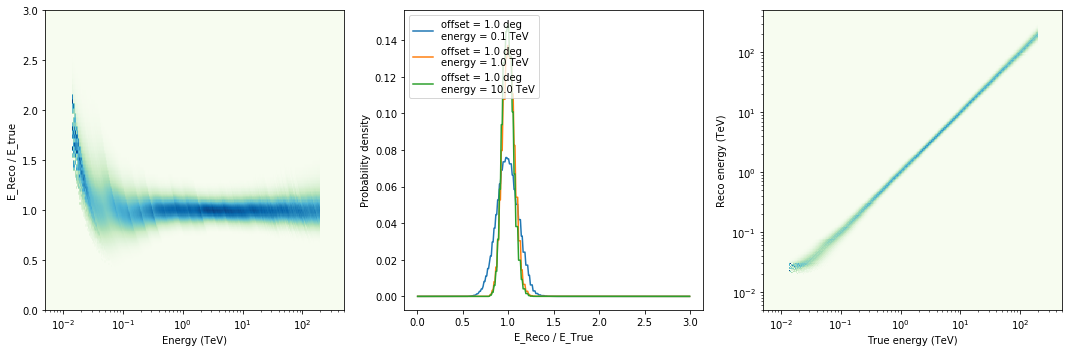

In [13]:
obs.edisp.peek()

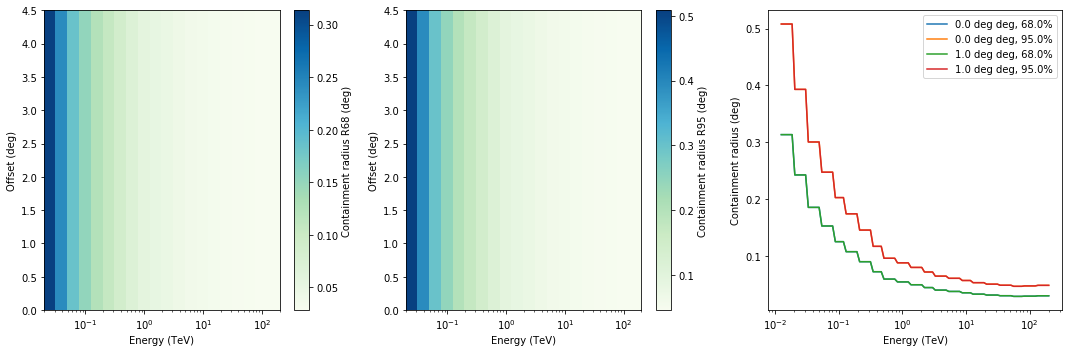

In [14]:
obs.psf.peek()

## Define inputs

Select the target position and define an ON region for the spectral analysis

In [15]:
target_position = SkyCoord(l=184.557466192, b=-5.78434365208, unit='deg', frame='galactic')
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

In [16]:
# Define reference image centered on the target
xref = target_position.galactic.l.value
yref = target_position.galactic.b.value
# size = 10 * u.deg
# binsz = 0.02 # degree per pixel
# npix = int((size / binsz).value)

ref_image = SkyImage.empty(
    nxpix=800, nypix=600, binsz=0.02,
    xref=xref, yref=yref,
    proj='TAN', coordsys='GAL',
)
print(ref_image)

Name: None
Data shape: (600, 800)
Data type: float64
Data unit: 
Data mean: 0.000e+00
WCS type: ['GLON-TAN', 'GLAT-TAN']



(<matplotlib.figure.Figure at 0x891b450>,
 None)

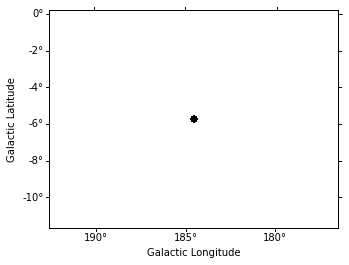

In [17]:
exclusion_mask = ref_image.region_mask(on_region)
exclusion_mask.data = 1 - exclusion_mask.data
exclusion_mask.plot()

## Make maps

Standard analysis products: Counts and Significance images

In [18]:
bkg_estimator = RingBackgroundEstimator(
    r_in=0.5 * u.deg,
    width=0.2 * u.deg,
)
image_estimator = IACTBasicImageEstimator(
    reference=ref_image,
    emin=50 * u.GeV,
    emax=20 * u.TeV,
    offset_max=3 * u.deg,
    background_estimator=bkg_estimator,
    exclusion_mask=exclusion_mask,
)
images = image_estimator.run(obs_list)
images.names

/usr/lib64/python2.7/site-packages/gammapy/cube/core.py:85: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)
/usr/lib64/python2.7/site-packages/scipy/interpolate/interpolate.py:2444: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/usr/lib64/python2.7/site-packages/gammapy/background/ring.py:321: RuntimeWarning: invalid value encountered in true_divide
  result['alpha'] = SkyImage(data=exposure_on.data / result['exposure_off'].data, wcs=wcs)


[u'counts', u'exposure', u'background', u'excess', u'flux', u'psf']

In [19]:
def show_image(image, radius=3, vmin=0, vmax=3):
    """Little helper function to show the images for this application here."""
    image.smooth(radius=radius).show(vmin=vmin, vmax=vmax, add_cbar=True)
    image.cutout(
        position=SkyCoord(xref, yref, unit='deg', frame='galactic'),
        size=(2*u.deg, 3*u.deg),
    ).smooth(radius=radius).show(vmin=vmin, vmax=vmax, add_cbar=True)

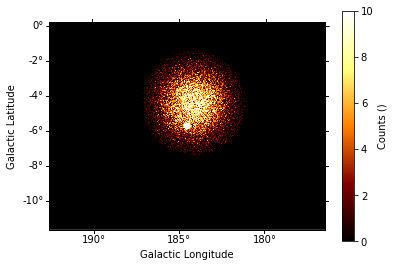

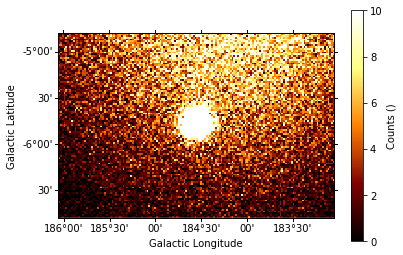

In [20]:
show_image(images['counts'], radius=0, vmax=10)

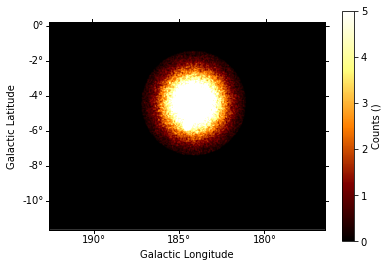

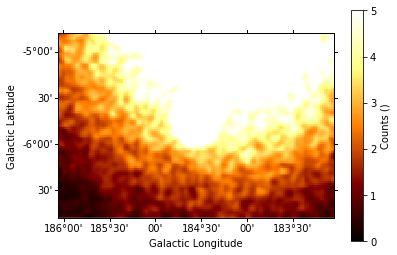

In [21]:
show_image(images['counts'], vmax=5)

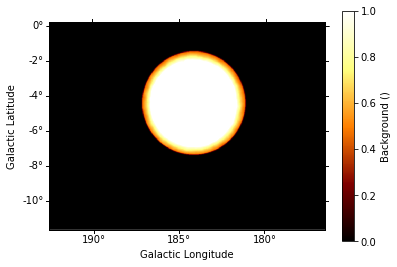

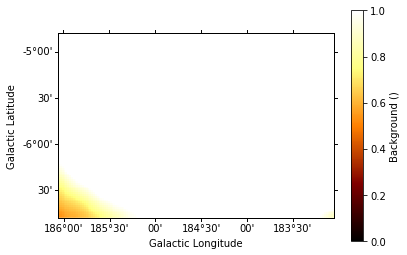

In [22]:
show_image(images['background'], vmax=1)

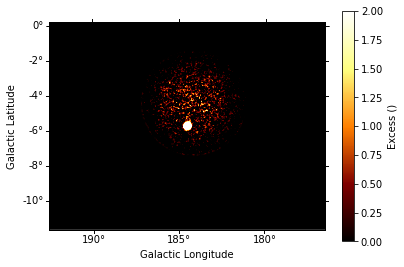

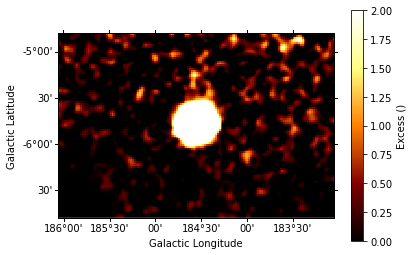

In [23]:
show_image(images['excess'], vmax=2)

/usr/lib64/python2.7/site-packages/gammapy/stats/poisson.py:254: RuntimeWarning: divide by zero encountered in true_divide
  term_b = sqrt(n_on * log(n_on / mu_bkg) - n_on + mu_bkg)


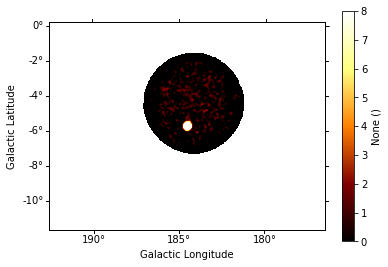

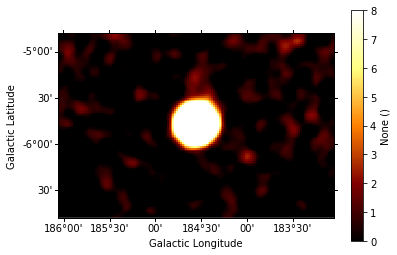

In [24]:
# Significance image
# Just for fun, let's compute it by hand ...
from astropy.convolution import Tophat2DKernel
kernel = Tophat2DKernel(4)
kernel.normalize('peak')

counts_conv = images['counts'].convolve(kernel.array)
background_conv = images['background'].convolve(kernel.array)

from gammapy.stats import significance
significance_image = SkyImage.empty_like(ref_image)
significance_image.data = significance(counts_conv.data, background_conv.data)
show_image(significance_image, vmax=8)

## Source Detection

Use the class [TSImageEstimator](http://docs.gammapy.org/en/latest/api/gammapy.detect.compute_ts_image.html#gammapy.detect.TSImageEstimator.html) and [photutils.find_peaks](http://photutils.readthedocs.io/en/stable/api/photutils.find_peaks.html) to detect point-like sources on the images:

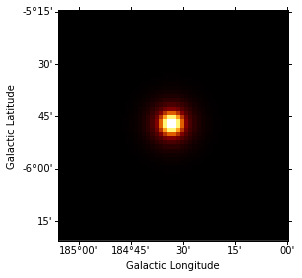

In [25]:
# cut out smaller piece of the PSF image to save computing time
# for covenience we're "misusing" the SkyImage class represent the PSF on the sky.
kernel = images['psf'].cutout(target_position, size= 1.1 * u.deg)
kernel.show()

In [26]:
ts_image_estimator = TSImageEstimator()
images_ts = ts_image_estimator.run(images, kernel.data)
print(images_ts.names)

[u'ts', u'sqrt_ts', u'flux', u'flux_err', u'flux_ul', u'niter']


In [27]:
# find pointlike sources with sqrt(TS) > 5
sources = find_peaks(data=images_ts['sqrt_ts'].data, threshold=5, wcs=images_ts['sqrt_ts'].wcs)
sources

/usr/lib64/python2.7/site-packages/photutils/detection/core.py:241: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))


x_peak,y_peak,icrs_ra_peak,icrs_dec_peak,peak_value
,,deg,deg,
int64,int64,float64,float64,float64
400,299,83.6182147055,22.017592628,217.49301756


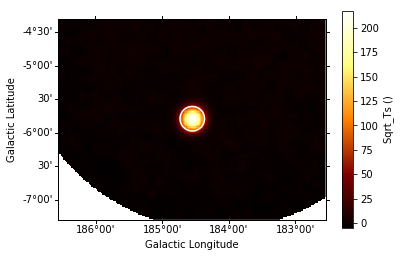

In [28]:
# Plot sources on top of significance sky image
images_ts['sqrt_ts'].cutout(
    position=SkyCoord(l=184.557466192, b=-5.78434365208, unit='deg', frame='galactic'),
    size=(3*u.deg, 4*u.deg)
).plot(add_cbar=True)

plt.gca().scatter(
    sources['icrs_ra_peak'], sources['icrs_dec_peak'],
    transform=plt.gca().get_transform('icrs'),
    color='none', edgecolor='white', marker='o', s=600, lw=1.5,
)

# Spectrum

Standard analysis products: Spectrum and flux points

(<matplotlib.figure.Figure at 0x26866b90>,
 None)

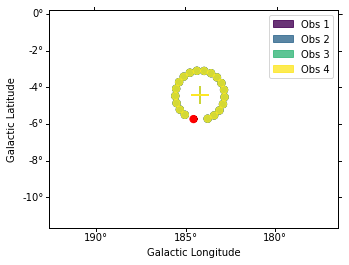

In [29]:
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    obs_list=obs_list,
    on_region=on_region,
    exclusion_mask=exclusion_mask,
)
bkg_estimator.run()
bkg_estimate = bkg_estimator.result
bkg_estimator.plot()

In [30]:
extract = SpectrumExtraction(
    obs_list=obs_list,
    bkg_estimate=bkg_estimate,
)
extract.run()

In [31]:
model = models.PowerLaw(
    index = 2.2 * u.Unit(''),
    amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference = 1 * u.TeV,
)

fit = SpectrumFit(extract.observations, model)
fit.fit()
fit.est_errors()
print(fit.result[0])

/usr/lib64/python2.7/site-packages/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/usr/lib64/python2.7/site-packages/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/usr/lib64/python2.7/site-packages/gammapy/stats/fit_statistics.py:198: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/usr/lib64/python2.7/site-packages/gammapy/stats/fit_statistics.py:199: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))



Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit      min  max  frozen
	--------- --------- --------- --------------- ---- ---- ------
	    index 2.293e+00 6.245e-03                    0 None  False
	amplitude 3.730e-11 4.650e-13 1 / (cm2 s TeV)    0 None  False
	reference 1.000e+00 0.000e+00             TeV None None   True

Covariance: 

	name/name   index   amplitude
	--------- --------- ---------
	    index   3.9e-05 -1.75e-15
	amplitude -1.75e-15  2.16e-25 

Statistic: 727.747 (wstat)
Fit Range: [  1.00000000e-02   1.00000000e+02] TeV



In [32]:
# Flux points are computed on stacked observation
stacked_obs = extract.observations.stack()
print(stacked_obs)

ebounds = EnergyBounds.equal_log_spacing(0.05, 20, 4, unit = u.TeV)

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

fpe = FluxPointEstimator(
    obs=stacked_obs,
    groups=seg.groups,
    model=fit.result[0].model,
)
fpe.compute_points()
fpe.flux_points.table

*** Observation summary report ***
Observation Id: [1-4]
Livetime: 1.900 h
On events: 13020
Off events: 26533
Alpha: 0.053
Bkg events in On region: 1396.47
Excess: 11623.53
Excess / Background: 8.32
Gamma rate: 1.42 1 / min
Bkg rate: 0.17 1 / min
Sigma: 174.96
energy range: 0.01 TeV - 100.00 TeV


/usr/lib64/python2.7/site-packages/gammapy/stats/poisson.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  temp = (alpha + 1) / (n_on + n_off)


e_ref,e_min,e_max,dnde,dnde_err,dnde_ul,is_ul,sqrt_ts,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,bool,float64,float64,float64
0.106605049898,0.052749970637,0.215443469003,7.39111296753e-09,1.06119665264e-10,7.62371882159e-09,False,116.407984145,1.21378593176e-10,1.23059418462e-10
0.464158883361,0.215443469003,1.0,2.73039990949e-10,4.55349425333e-12,2.82003235053e-10,False,118.921257503,4.32005115151e-12,4.26645385109e-12
2.02094993819,1.0,4.08423865267,7.07859408702e-12,1.90174400048e-13,7.47036467329e-12,False,79.9597069474,2.05950715796e-13,2.04529764247e-13
8.79922543569,4.08423865267,18.9573565241,1.64504843387e-13,8.08998697083e-15,1.81033028077e-13,False,44.211696916,8.3762043157e-15,8.23980823236e-15


(<matplotlib.axes._subplots.AxesSubplot at 0x26a48c10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a8c8c90>)

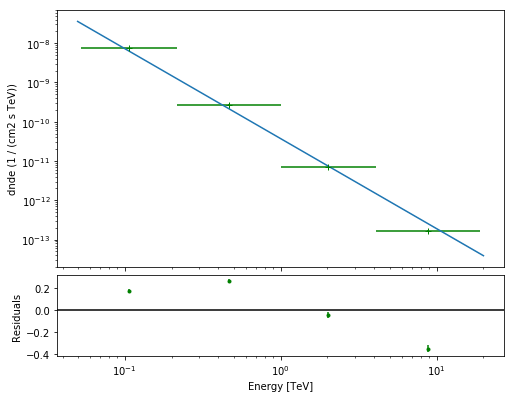

In [33]:
total_result = SpectrumResult(
    model=fit.result[0].model,
    points=fpe.flux_points,
)

total_result.plot(
    energy_range = [0.05, 20] * u.TeV,
    fig_kwargs=dict(figsize=(8,8)),
    point_kwargs=dict(color='green'),
)